(Note: Figures may differ somewhat from original paper since we updated to more recent version of sklearn, see README for exact replication)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import partial_dependence

import helpers  # Notebook helper functions

sys.path.append(os.path.join('..'))
from adp.curve import * 
from adp.utility import *
from adp.plot import *
from adp.funcs import *
from adp.optim import *

In [2]:
# Fetch/download data
D = helpers.fetch_german_data()
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# Numeric only
numeric = ~is_categorical(dtypes)
X = X[:, numeric]
feature_labels = feature_labels[numeric]
dtypes = dtypes[numeric]

# Get train test splits
X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('# train', len(y_train))
print('# test', len(y_test))

# Setup sample data for PDP/ICE/ADP plots
rng = check_random_state(0)
rand_idx = rng.permutation(X.shape[0])
n_X_samples = 100
X_sample = X[rand_idx[:n_X_samples]]

# train 900
# test 100


In [3]:
# Train models
model_names = ['RandomForest', 'GradientBoost', 'DNN']
model_dicts = helpers.create_and_train_models(
    model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test)

Loading fitted model from cache via file cached_model_d5d4430e323b00ba39bc64e7d3b56056a6040b8e.pkl
Loading fitted model from cache via file cached_model_daaa9d006a7ac9ac191d52e2146c5ca18ebae2b2.pkl
Loading fitted model from cache via file cached_model_ee48924d58e411b8367991894f08fd001faa2c5d.pkl


In [4]:
def plot_models(get_feature_vals, label, model_dicts, n_grid=100, save=True):
    n_rows, n_cols = 1, len(model_dicts)
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=np.array([n_cols*4, n_rows*2.5])*0.9, dpi=100)

    for jj, (d, ax) in enumerate(zip(model_dicts, axes)):
        model = d['model']
        estimator = d['estimator'].best_estimator_

        max_var = 0
        for i, name in enumerate(feature_labels):
            xvals, yvals, target_idx = get_feature_vals(X_sample, estimator, model, i, n_grid) 
            var = np.var(yvals)
            #print(var, i, name)
            if var >= max_var:
                max_var = var
                best_xvals = xvals
                best_yvals = yvals
                best_target_idx = target_idx
                best_feature_name = name

        if target_idx is not None:
            ax.scatter(best_xvals[best_target_idx], best_yvals[best_target_idx],
                       color='r', label='Target', zorder=2)
        ax.plot(best_xvals, best_yvals, label=label, zorder=1)
        ax.set_xlabel(best_feature_name)
        ax.legend()
        if jj == 0:
            ax.set_ylabel(label, fontsize=30)
        ax.set_title('%s (train=%.2f, test=%.2f)\n Variance=%.3f' 
                     % (d['model_name'], d['train_score'], d['test_score'], max_var))
    fig.tight_layout()
    if save:
        plt.savefig(f'comparison-{label.lower()}.pdf', bbox_inches='tight', pad_inches=0.1)

Automatic pdb calling has been turned ON


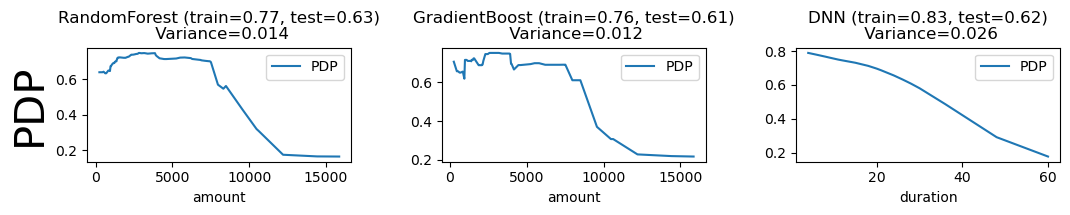

In [5]:
%pdb on
from sklearn.inspection import partial_dependence
def pdp_get_feature_vals(X_sample, estimator, model, feature_idx, n_grid):
    if len(np.unique(X_sample[:, feature_idx])) == 2:
        # No variance if only 2 unique values so return dummy values
        #  (sklearn's PDP evaluates the function at n_unqiue-1 points which
        #   causes error in sklearn's PDP)
        return [0], [0], None
    pd_res = partial_dependence(estimator, X_sample, 
                                [feature_idx], grid_resolution=n_grid) 
    avg_pred = pd_res[0][0]
    xvals = pd_res[1][0]
    return xvals, avg_pred, None

plot_models(pdp_get_feature_vals, 'PDP', model_dicts)

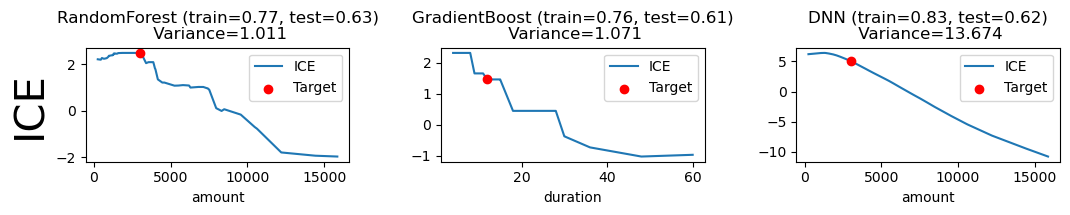

In [6]:
from ice import ice
def ice_get_feature_vals(X_sample, estimator, model, feature_idx, n_grid):
    X_df = pd.DataFrame(X_sample, columns=feature_labels)
    ice_df = ice(X_df, feature_labels[feature_idx], model, num_grid_points=n_grid)
    ice_numpy = ice_df.to_numpy()
    xvals = np.array(ice_df.axes[0].tolist())
    
    # Find highest variance out of samples
    stds = np.std(ice_numpy, axis = 0)
    best_sample_idx = np.argmax(stds)
    yvals = ice_df.iloc[:, best_sample_idx].to_numpy()
    target_idx = np.argmin(np.abs(xvals - X_sample[best_sample_idx, feature_idx]))
    
    return xvals, yvals, target_idx

plot_models(ice_get_feature_vals, 'ICE', model_dicts)

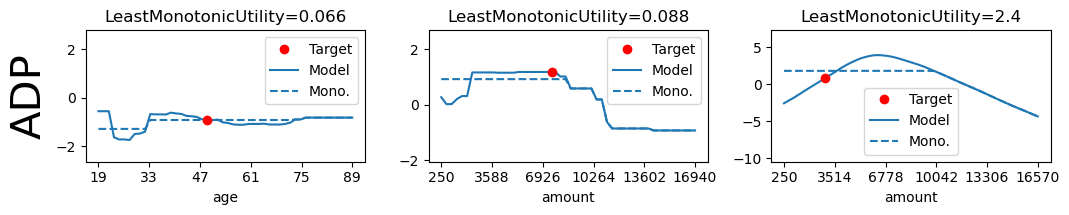

In [7]:
n_grid = 50
U = lambda model, x0: LeastMonotonicUtility(model)

n_rows, n_cols = 1, len(model_dicts)
fig, axes = plt.subplots(n_rows, n_cols, figsize=np.array([n_cols*4, n_rows*2.5])*0.9, dpi=100)
for jj, (d, ax) in enumerate(zip(model_dicts, axes)):
    model = d['model']
    model_scores = model(X)
    y_bounds = [np.min(model_scores), np.max(model_scores)]

    # Fit for every sample
    utilities_per_x0 = np.array([U(model=model, x0=xx) for xx in X_sample])
    best_curves = np.array([
        optimize_curve(x0=xx, utility=uu, X=X, dtypes=dtypes, max_numeric_change=1)
        for xx, uu in zip(X_sample, utilities_per_x0)
    ])
    best_utilities = np.array([uu(best_curve, n_grid=n_grid) 
                               for best_curve, uu in zip(best_curves, utilities_per_x0)])

    # Choose best sample
    best_idx = np.argmax(best_utilities)
    best_curve = best_curves[best_idx]
    best_utility = utilities_per_x0[best_idx]

    # Plot
    plot_curve_vals(curve=best_curve, utility=best_utility, feature_labels=feature_labels, y_bounds=y_bounds,
                    tick_rotation=15, ax=ax, 
                    model_label='Model', other_model_label='Mono.',
                    legend_kwargs=dict(loc='best'))
    if jj == 0:
        ax.set_ylabel('ADP', fontsize=30)
fig.tight_layout()
plt.savefig('comparison-adp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('comparison-adp-gray.pdf', bbox_inches='tight', pad_inches=0.1, facecolor=[0.9, 0.9, 0.9])